In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def cvtToPos(feat_map): # feat_map = [cx, cy, w, h]
    left_upper_x = feat_map[0] - int(feat_map[2]/2)
    left_upper_y = feat_map[1] - int(feat_map[3]/2)
    right_lower_x = feat_map[0] + int(feat_map[2]/2)
    right_lower_y = feat_map[1] + int(feat_map[3]/2)
    return np.array([left_upper_x, left_upper_y, right_lower_x, right_lower_y]).astype(np.int32)

def cvtEdge2Center(rect): # rect = [left_upper_x, left_upper_y, w, h]
    cx = rect[0] + int(rect[2]/2)
    cy = rect[1] + int(rect[3]/2)
    return np.array([cx, cy, rect[2], rect[3]]).astype(np.int32)

In [3]:
# compute feature map positions
def generate_feature_maps(imgage_size=(300, 300), #(width, height)
                           div_width=5,
                           div_height=5):
    feat_maps = []
    
    im_w = imgage_size[1]
    im_h = imgage_size[0]

    feat_w = int(im_w / div_width)
    feat_h = int(im_h / div_height)

    feat_c_x = np.array([int(feat_w / 2) + 1 + n * feat_w for n in range(div_width)])
    feat_c_y = np.array([int(feat_h / 2)+ 1 + n * feat_h for n in range(div_height)])

    for j in range(div_height):
        for i in range(div_width):
            feat_maps.append(np.array([feat_c_x[i],
                                       feat_c_y[j],
                                       feat_w,
                                       feat_h]))
            
    return feat_maps #(cx, cy, w, h) 

In [4]:
def generate_scales(smin, smax, num_map):
    return smin + (smax - smin) / (num_map - 1) * np.array([k - 1 for k in range(num_map)])

In [5]:
def generate_default_boxes(feat_maps, aspects, scales):
    num_map = len(feat_maps)
    num_asp = len(aspects)
    num_scale = len(scales)
    def_boxes = np.zeros([num_map, num_asp, num_scale, 4])
    for i, feat in enumerate(feat_maps): 
        for j, ar in enumerate(aspects):
            for k, sk in enumerate(scales):
                w = int(feat[2] * sk * ar **0.5)
                h = int(feat[3] * sk * (1/ar) ** 0.5)
                def_boxes[i, j, k] = np.array([feat[0],
                                               feat[1],
                                               w,
                                               h])
    return def_boxes

In [6]:
def normalize(target, ref): # ref might be default box
    cx = (target[0] - ref[0]) / ref[2]
    cy = (target[1] - ref[1]) / ref[3]
    w = np.log(target[2]/ref[2])
    h = np.log(target[3]/ref[3])
    return np.array([cx, cy, w,h])

def smoothL1(target, ref):
    diffs = target - ref
    for m in range(4):
        if diffs[m] > 1:
            diffs[m] = diffs[m] -  0.5
        else:
            diffs[m] = 0.5 * diffs[m] ** 2
    return diffs.sum()

In [7]:
def box_area(box): #box = [cx, cy, w, h]
    return box[2] * box[3]

def cross_area(tar_box, ref_box):# todo: when indexes are out of range
    pixels = 0
    ref_area = cvtToPos(ref_box)
    tar_area = cvtToPos(tar_box)
    for i in range(tar_box[2]):
        for j in range(tar_box[3]):
            w_bool = tar_area[0] + i >= ref_area[0] and tar_area[0] + i <= ref_area[2]
            h_bool = tar_area[1] + j >= ref_area[1] and tar_area[1] + j <= ref_area[3]
            if w_bool and h_bool:
                pixels += 1
    return pixels

def IoU(tar_box, ref_box):
    return cross_area(tar_box, ref_box)/(box_area(tar_box) + box_area(ref_box))

In [8]:
image_path = 'test.jpg'
image = Image.open(image_path)
print(image.format, image.size, image.mode)

JPEG (710, 398) RGB


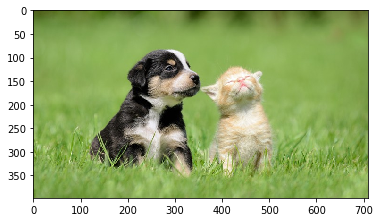

In [9]:
im_original = cv2.imread(image_path)
im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
plt.imshow(im_original)

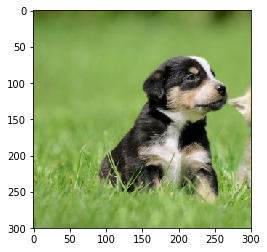

In [10]:
x = 0
y = 0
w = min(im_original .shape[0:2])
h = min(im_original .shape[0:2])
im = im_original[y:y+h, x:x+w]
im = cv2.resize(im,(300,300))
plt.imshow(im)

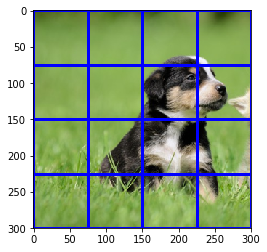

In [11]:
feat_maps = generate_feature_maps(im.shape[0:2],
                           div_width=4,
                           div_height=4)
color = (0, 0, 255)
for b in feat_maps:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

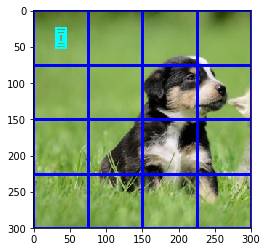

In [12]:
scales = generate_scales(0.2, 0.9, 10)
aspects = [1/2, 1, 2]
def_boxes = generate_default_boxes(feat_maps, aspects, scales)
color = (0, 255, 255)
for b in def_boxes.reshape([-1,4])[0:3]:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

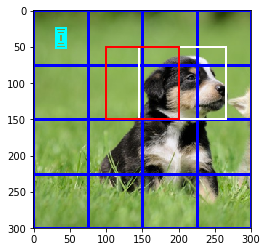

In [13]:
pred_box = np.array([[150, 100, 100, 100]])
gt_box = np.array([[205, 100, 120, 100]])

color = (255, 255, 255)
rect = cvtToPos(gt_box[0])
cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
color = (255, 0, 0)
for b in pred_box:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

In [14]:
norm_gt_box = []
norm_pred_box = []
for d in def_boxes.reshape([-1,4]):
    norm_gt_box.append(normalize(gt_box[0], d))
    norm_pred_box.append(normalize(pred_box[0], d)) 

In [15]:
IoUs = []
for b in def_boxes.reshape([-1,4]):
    IoUs.append(IoU(gt_box[0], b))
IoUs = np.array(IoUs)

In [16]:
loss = 0
for j in np.where(IoUs>0.1)[0]:
    loss += smoothL1(norm_gt_box[j], norm_pred_box[j])

In [17]:
loss

13.838190126735403

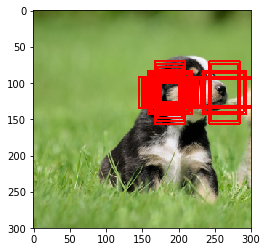

In [18]:
x = 0
y = 0
w = min(im_original .shape[0:2])
h = min(im_original .shape[0:2])
im = im_original[y:y+h, x:x+w]
im = cv2.resize(im,(300,300))

for b in def_boxes.reshape([-1,4])[np.where(IoUs>0.1)[0]]:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)